In [23]:
import numpy as np
import pandas as pd
import glob

#preprocessing data tools
from sklearn.preprocessing import MinMaxScaler
from numpy.fft import fft, fftfreq
from scipy import signal
from scipy.io import wavfile

#KNN
from sklearn import neighbors, datasets

#neural network tools
#camadas possíveis
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv1D,MaxPooling1D,UpSampling1D
from keras.layers.normalization import BatchNormalization

#leakyrelu permite um gradiente pequeno quando o neurônio não está ativo.
#ela tem uma pequena parte quando potencial de ação é negativo
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model,Sequential
from keras.optimizers import Adadelta, RMSprop,SGD,Adam, Nadam
from keras import regularizers
#é sempre bom utilizar callbacks para evitar problemas durante a convergência do algoritmo
from keras import callbacks

#kfold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#ferramentas gráficas
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import chart_studio
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Importando os Dados

In [24]:
path = "/home/gabriel/Downloads/freq/*.wav"
ys = []
fnames = []
y = []
cont = 0
resh = True #habilita ou desabilita divisão dos dados em dados menores.
for fname in sorted(glob.glob(path)): #utiliza a biblioteca glob para varrer a pasta na qual os arquivos (loop)
    
    waveF = []
    fnames.append(fname) 
    print(fname)
    #lê p .wav
    fs, data = wavfile.read(fname)
    #limitando o tamanho das amostras, porque devido ao fato do sensor variar o tamanho da amostra pelo clique do
    #operador, é necessário normalizar
    data = np.array(data[0:150000])
    #dividindo em 10 partes de 15000 amostras, que dá quase um segundo.
    if(resh == True):
        data = np.reshape(data,(10,15000))
        for d in data:
            y.append(d) #adiciona ao vetor de dadas linha a linha os dados
    else:        
        y.append(data)
    if(cont == 13):
        break
    cont += 1

#pega o nome dos arquivos, remove o path deles por espaço.
fnames = [f.replace('C:\\Users\\gabriel.gomes\\Google Drive\\Radice - Pós-Graduação\Disciplinas\Trabalho Final - \
SEL5712 e SEL5742\\Arquivos de Dados\Amostras Aleatórias\\', '') for f in fnames]

#converte y para dataframe
df = pd.DataFrame(np.array(y))

#criando o nome das colunas para o dataframe

#20 = 10 de um lado, 10 do outro
n_samples = 14
index = []
j = 0

if(resh == True):
    for i in range(n_samples*10):
        if(i%n_samples == 0 and i > 0):
            j += 1 
        #da o nome de Amostra (Am) x, parte y (com parte variando de 1 
        #até o número de partes no qual os dados foram divididos)
        index.append("Am." + str(int(i/n_samples)+1) + "p." + str(i-j*n_samples))
else:
    for i in range(n_samples):
        index.append("Am." + str(i))
        
df.index = index
#definindo os labels das amostras: 0 -> sem defeito; 1 -> com defeito
#Assim como cortou as amostras, tem que cortar os labels
n_def = 4;
n_ok = 3;
labels = []
labels[0:int(10*(n_def/(n_ok+n_def))*n_samples+1)] = [1 for i in range(int(10*(n_def/(n_ok+n_def))*n_samples+1))]
labels[int(10*(n_def/(n_ok+n_def))*n_samples+1):] = [0 for i in range(int(10*(n_def/(n_ok+n_def))*n_samples+1),10*n_samples)]
labels = pd.DataFrame(labels)
labels.index = index
#confere se os labels estão ok.
labels.head()

labels_orig = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

/home/gabriel/Downloads/freq/T01_W001_254509454251 Medida 1.wav
/home/gabriel/Downloads/freq/T01_W001_254509457843 Medida 2.wav
/home/gabriel/Downloads/freq/T02_W001_254509457836 Medida 1.wav
/home/gabriel/Downloads/freq/T02_W002_254509457930 Medida 2.wav
/home/gabriel/Downloads/freq/T03_W001_254509457847 Medida 1.wav
/home/gabriel/Downloads/freq/T03_W002_254509457930 Medida 2.wav
/home/gabriel/Downloads/freq/T04_W001_254509457847 Medida 1.wav
/home/gabriel/Downloads/freq/T04_W002_254509457950 Medida 2.wav
/home/gabriel/Downloads/freq/T05_W001_254509457819 Medida 1.wav
/home/gabriel/Downloads/freq/T05_W001_254509457819 Medida 2.wav
/home/gabriel/Downloads/freq/T06_W001_254509457815 Medida 1.wav
/home/gabriel/Downloads/freq/T06_W002_254509457853 Medida 2.wav
/home/gabriel/Downloads/freq/T07_W001_254509457835 Medida 1.wav
/home/gabriel/Downloads/freq/T07_W002_254509457925 Medida 2.wav


In [25]:
fnames

['/home/gabriel/Downloads/freq/T01_W001_254509454251 Medida 1.wav',
 '/home/gabriel/Downloads/freq/T01_W001_254509457843 Medida 2.wav',
 '/home/gabriel/Downloads/freq/T02_W001_254509457836 Medida 1.wav',
 '/home/gabriel/Downloads/freq/T02_W002_254509457930 Medida 2.wav',
 '/home/gabriel/Downloads/freq/T03_W001_254509457847 Medida 1.wav',
 '/home/gabriel/Downloads/freq/T03_W002_254509457930 Medida 2.wav',
 '/home/gabriel/Downloads/freq/T04_W001_254509457847 Medida 1.wav',
 '/home/gabriel/Downloads/freq/T04_W002_254509457950 Medida 2.wav',
 '/home/gabriel/Downloads/freq/T05_W001_254509457819 Medida 1.wav',
 '/home/gabriel/Downloads/freq/T05_W001_254509457819 Medida 2.wav',
 '/home/gabriel/Downloads/freq/T06_W001_254509457815 Medida 1.wav',
 '/home/gabriel/Downloads/freq/T06_W002_254509457853 Medida 2.wav',
 '/home/gabriel/Downloads/freq/T07_W001_254509457835 Medida 1.wav',
 '/home/gabriel/Downloads/freq/T07_W002_254509457925 Medida 2.wav']

In [26]:
#conferindo se os labels foram colocados de maneira corrreta
pd.value_counts(labels.iloc[:][0])

1    80
0    60
Name: 0, dtype: int64

# Análise do espectro de frequência dos sinais e classificação por espectro de frequência
Análise da resposta em frequência dos sinais sem defeito e dos sinais com defeito. Foi utilizada a FFT média para analisar a semelhança ou diferença entre os espectros médios.

In [27]:
#faz a fft de uma linha só para não ter que ficar fazendo toda hora
#uma análise diferente do tamanho do vetor
window = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f, Pxx_den = signal.periodogram(df.iloc[0][:], fs)
Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
meanf_ok = Pxx_den - Pxx_den #cria vetor de nulos
meanf_nok = Pxx_den - Pxx_den #cria vetor de nulos
count_ok = 0
count_nok = 0
fourier = []
#faz a média dos espectros de frequência com defeito e sem defeito
for i in range(len(df)):
    f, Pxx_den = signal.periodogram(df.iloc[i][:], fs)
    Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
    if(labels.iloc[i][0] == 0):
        #meanf_ok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den)) #normalizando os coeficientes.
        meanf_ok += Pxx_den/max(Pxx_den)
        fourier.append((Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))) #resultado da transformada de Fourier
        count_ok += 1
    else:
        fourier.append((Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))) #resultado da transformada de Fourier
        meanf_nok += Pxx_den/max(Pxx_den)
        #?meanf_nok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))
        count_nok += 1

f = f[0:len(meanf_ok)]


### Transformada de Fourier Janelada de um sinal com defeito e um sem

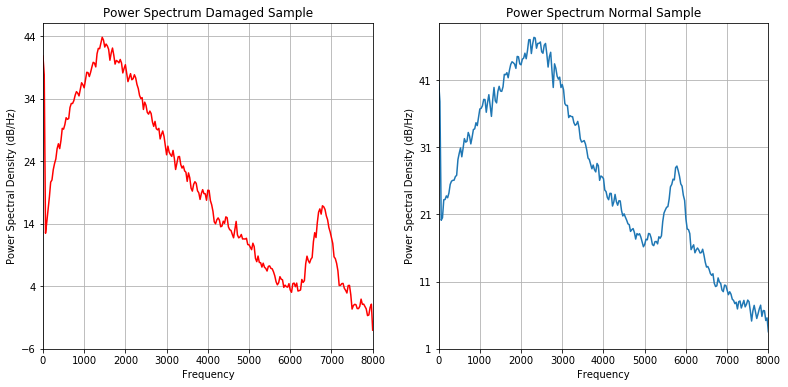

In [28]:
#amostras individuais
plt.figure(figsize=(13, 6))
plt.subplot(1,2,1)
plt.psd(df.iloc[0][:],512,fs, c = 'r')
plt.title("Power Spectrum Damaged Sample")
plt.xlim([0, 8000])
plt.subplot(1,2,2)
plt.psd(df.iloc[13][:],512,fs)
plt.title("Power Spectrum Normal Sample")
plt.xlim([0, 8000])
plt.show()

### Expectro médio de Fourier

In [29]:
        
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)


#cria um dataframe dos isoladores com defeito e sem defeito
# fourier_df = pd.DataFrame(np.array([f, meanf_nok, meanf_ok]).T)
# fourier_df.columns = ["Frequency [Hz]", "Broken", "Normal"]
# fourier_df.head()
f_df = pd.DataFrame(f.T)
f_df.columns = ["Frequency"]
meanf_nok_df = pd.DataFrame(meanf_nok.T)
meanf_nok_df.columns = ["Broken Insulator"]
meanf_ok_df = pd.DataFrame(meanf_ok.T)
meanf_ok_df.columns = ["Normal Insulator"]
# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))

#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_nok_df['Broken Insulator'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_ok_df['Normal Insulator'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_nok_df['Broken Insulator'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=f_df['Frequency'],y=meanf_ok_df['Normal Insulator'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Frequency [Hz]',
                   yaxis_title='Modulus')

fig.show()

## Cortando o espectro

O espectro será cortado acima de 500 Hz e abaixo de 3000 Hz. Isso porque eles são iguais nessas regiões.

In [30]:
#Cortando na região de interesse

fu_cutted = []
f_cut_sup = 3000
f_cut_inf = 500
l_inf = int(f_cut_inf*len(f_df)/8000)
l_sup = int(f_cut_sup*len(f_df)/8000)
for fou in np.array(fourier):
    fu_cutted.append(fou[l_inf:l_sup])
meanf_ok = fu_cutted[0] - fu_cutted[0] #cria vetor de nulos
meanf_nok = fu_cutted[0]- fu_cutted[0] #cria vetor de nulos

    
    
for i in range(len(fu_cutted)):
    if(labels.iloc[i][0] == 0):
        #meanf_ok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den)) #normalizando os coeficientes.
        meanf_ok += fu_cutted[i]/max(fu_cutted[i])
        count_ok += 1
    else:
        meanf_nok += fu_cutted[i]/max(fu_cutted[i])
        #?meanf_nok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))
        count_nok += 1

In [31]:

#cortando o espectro de frequência
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)

f = [i for i in range(len(meanf_ok))] #cria o vetor de tempo
#cria um dataframe dos isoladores com defeito e sem defeito
fourier_df = pd.DataFrame(np.array([f, meanf_nok, meanf_ok]).T)
fourier_df.columns = ["Frequency [Hz]", "Broken", "Normal"]
fourier_df.head()

# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))

#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Samples',
                   yaxis_title='Modulus')

fig.show()

Como é possível ver, existe uma diferença média no espectro entre 1000 e 2000 Hz. Portanto, os espectros médios da janela são diferentes! Logo, podemos utilizar a transformada de Fourier Janelada para fazer a análise.

Como a transformada de Fourier possui muitas amostras, no caso, 2344, devemos fazer uma reamostragem para tornar isso compatível com a rede. Iremos fazer isso utilizando uma subamostragem por Fourier (vulgo método de compactação de MP3)! Essa subamostragem por Fourier se comporta como uma compactação. 

In [32]:
# nas redes neurais.
data = signal.resample(fu_cutted,30,axis = 1) #subamostrando segundo as colunas.

# comparar o signal reconstruído com o subamostrado
fourier_recomp = signal.resample(data,len(fu_cutted[0]), axis = 1)

In [33]:
#Coeficiente de correlação foi para 0.71 porem, o importante é saber se o espectro médio atinda tem diferença!
corr = []
for i in range(140):
    corr.append(np.corrcoef(fourier_recomp[i], fu_cutted[i]))

print("Valor Mínimo: ", np.min(corr))
print("Valor Máximo: ", np.max(corr))
    

Valor Mínimo:  0.9969426255872201
Valor Máximo:  1.0


## análise do sinal compactado
Foi analisada a compactação do sinal para ver se ela ainda mantinha a separabilidade entre os espectros médios.

In [34]:
#faz a média dos espectros de frequência com defeito e sem defeito subamostrados
meanf_ok = data[1] - data[1] #cria vetor de nulos
meanf_nok = data[1] - data[1]#cria vetor de nulos
count_ok = 0
count_nok = 0
fourier_norm = [] #fourier normalizado
for i in range(len(labels)):
    if(labels.iloc[i][0] == 0):
        data[i] = (data[i]/max(data[i])) #normaliza o dado pelo máximo
        meanf_ok += data[i]
        count_ok += 1 #contador para verificar se o número de amostras sem defeito está correto
    else:
        data[i] = (data[i]/max(data[i]))
        meanf_nok += data[i]
        count_nok += 1 #contador para verificar se o número de amostras com defeito está correto

In [35]:
        
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)

f = [i for i in range(len(meanf_ok))] #cria o vetor de tempo
#cria um dataframe dos isoladores com defeito e sem defeito
fourier_df = pd.DataFrame(np.array([f, meanf_nok, meanf_ok]).T)
fourier_df.columns = ["Frequency [Hz]", "Broken", "Normal"]
fourier_df.head()

# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))

#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Samples',
                   yaxis_title='Modulus')

fig.show()

Como é possível perceber, a diferença no espectro de frequência foi preservada, logo essa abordagem pode ser utilizada.
Uma outra possibilidade é utilizar um PCA aqui. O problema é que como temos apenas 200 amostras, vai ser difícil preservar a variância porque o máximo de coeficientes possível serão 200, então nem compensa tentar. 


# Rede Neural

In [36]:
#colocando as informações no formato da rede. Tem que expandir uma dimensão
data = np.expand_dims(np.array(data),axis= 2) 

In [37]:
# # # #callbacks
# #hackeando os critérios de earlystop da biblioteca.
# #colocando para parar quando atinge a métrica desejada
# #NÃO FOI UTILIZADO NA VERSÃO FINAL DO TRABALHO
# class EarlyStoppingByLossVal(callbacks.Callback):
#      def __init__(self, monitor='custom', value=0.80, verbose=0):
#          super(callbacks.Callback, self).__init__()
#          self.monitor = monitor
#          self.value = value
#          self.verbose = verbose

#      def on_epoch_end(self, epoch, logs={}):
#          self.monitor = 'val_acc'
#          val_ac = logs.get(self.monitor)
#          self.monitor = 'acc'
#          ac = logs.get(self.monitor)
#          if (val_ac or ac)is None:
#              warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

#          if (val_ac >= self.value) and (ac >= self.value):
#              if self.verbose > 0:
#                  print("Epoch %05d: early stopping THR" % epoch)
#              self.model.stop_training = True

# callbacks = [
#     EarlyStoppingByLossVal(monitor='custom', value=0.80, verbose=1),
# ]

Usando k-fold cross validation

In [38]:
n_splits = 7
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)

In [39]:

cvscores = []
labels = np.array(labels)
arquitetura = []
for train, test in kfold.split(data, labels):
  # create model
    #identifica que o modelo ẽ sequencial, isto é, feedforward
    convolutional_NN = Sequential()
    convolutional_NN.add(Conv1D(30,kernel_size = 15, activation = 'relu', input_shape=(data.shape[1],1))) #kernel_size = 10
    convolutional_NN.add(Conv1D(40,kernel_size = 10, activation = 'relu')) #kernel_size = 5;
    convolutional_NN.add(Conv1D(60,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
    convolutional_NN.add(Conv1D(90,kernel_size = 2, activation = 'relu')) #kernel_size = 2;
#convolutional_NN.add(MaxPooling1D(2))
#     convolutional_NN.add(Dense(3, activation = 'sigmoid'))
    #quinta camada: MLP com 80 neurônios
    #dropout para evitar overfitting. Jogando fora 0.615 dos neurônios anteriores
#     convolutional_NN.add(Dropout(rate = 0.1))
    #flatten para colocar na forma de saída da rede
    convolutional_NN.add(Flatten())
    #camada de saída: MLP com 1 neurônio e função de ativação sigmoid
    convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    
    #Compila o modelo. Função de custo: erro médio quadrático. Otimizador: Adam.
    convolutional_NN.compile(loss='binary_crossentropy', optimizer = Nadam(),metrics=['accuracy'],  
                             )
    
    # Fit o modelo por 30 épocas e batch_size = 64. Já está validando também
    convolutional_NN.fit(data[train], labels[train], epochs=300, batch_size=140, verbose=1
                         , validation_data=(data[test], np.array(labels)[test]))
    # avalia o resultado
    scores = convolutional_NN.evaluate(data[test], np.array(labels)[test], verbose=0)
    arquitetura.append(convolutional_NN)
    print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# cvscores = []
# labels = np.array(labels)
# arquitetura = []
# for train, test in kfold.split(data, labels):
#   # create model
#     #identifica que o modelo ẽ sequencial, isto é, feedforward
#     convolutional_NN = Sequential()
#     #primeira camada: MLP com 100 neurônios
#     convolutional_NN.add(Dense(20, activation='relu',input_shape=(data.shape[1],1)))
#     #segunda camada: MLP convolucional com 100 filtros de tamanho 15
#     convolutional_NN.add(Conv1D(10,kernel_size = 15, activation = 'relu')) #kernel_size = 10
#     #max pooling1d para evitar overfitting
#     convolutional_NN.add(MaxPooling1D((2)))
#     #quarta camada: rede convolucional com 80 filtros.
#     convolutional_NN.add(Conv1D(10,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
#     #quinta camada: MLP com 80 neurônios
#     convolutional_NN.add(Dense(20, activation='relu'))
#     #dropout para evitar overfitting. Jogando fora 0.615 dos neurônios anteriores
#     convolutional_NN.add(Dropout(rate = 0.3))
#     #flatten para colocar na forma de saída da rede
#     convolutional_NN.add(Flatten())
#     #camada de saída: MLP com 1 neurônio e função de ativação sigmoid
#     convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    
#     #Compila o modelo. Função de custo: erro médio quadrático. Otimizador: Adam.
#     convolutional_NN.compile(loss='mean_squared_error', optimizer = Adam(),metrics=['accuracy'],  
#                              )
    
#     # Fit o modelo por 30 épocas e batch_size = 64. Já está validando também
#     convolutional_NN.fit(data[train], labels[train], epochs=200, batch_size=140, verbose=1
#                          , validation_data=(data[test], np.array(labels)[test]))
#     # avalia o resultado
#     scores = convolutional_NN.evaluate(data[test], np.array(labels)[test], verbose=0)
#     arquitetura.append(convolutional_NN)
#     print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))
#     cvscores.append(scores[1] * 100)
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 119 samples, validate on 21 samples
Epoch 1/300
119/119 [==============================] - 1s 9ms/step - loss: 0.6945 - acc: 0.4454 - val_loss: 0.6856 - val_acc: 0.5714
Epoch 2/300
119/119 [==============================] - 0s 51us/step - loss: 0.6850 - acc: 0.5714 - val_loss: 0.6776 - val_acc: 0.5714
Epoch 3/300
119/119 [==============================] - 0s 56us/step - loss: 0.6768 - acc: 0.5714 - val_loss: 0.6688 - val_acc: 0.5714
Epoch 4/300
119/119 [==============================] - 0s 60us/step - loss: 0.6675 - acc: 0.5714 - val_loss: 0.6631 - val_acc: 0.5714
Epoch 5/300
119/119 [==============================] - 0s 55us/step - loss: 0.6605 - acc: 0.5714 - val_loss: 0.6655 - val_acc: 0.5714
Epoch 6/300
119/119 [==============================] - 0s 119us/step - loss: 0.6640 - acc: 0.5714 - val_loss: 0.6761 - val_acc: 0.4762
Epoch 7/300
119/119 [==============================] - 0s 66us/step - loss: 0.6703 - acc: 0.4874 - val_loss: 0.6498 - val_acc: 0.5714
Epoch 8/300
119/1

Epoch 62/300
119/119 [==============================] - 0s 71us/step - loss: 0.4997 - acc: 0.7563 - val_loss: 0.6286 - val_acc: 0.6190
Epoch 63/300
119/119 [==============================] - 0s 63us/step - loss: 0.5402 - acc: 0.6807 - val_loss: 0.7136 - val_acc: 0.6190
Epoch 64/300
119/119 [==============================] - 0s 53us/step - loss: 0.6796 - acc: 0.6218 - val_loss: 0.6318 - val_acc: 0.6190
Epoch 65/300
119/119 [==============================] - 0s 81us/step - loss: 0.5821 - acc: 0.6471 - val_loss: 0.5531 - val_acc: 0.7619
Epoch 66/300
119/119 [==============================] - 0s 52us/step - loss: 0.5237 - acc: 0.7143 - val_loss: 0.5539 - val_acc: 0.7143
Epoch 67/300
119/119 [==============================] - 0s 56us/step - loss: 0.5064 - acc: 0.7647 - val_loss: 0.5519 - val_acc: 0.7143
Epoch 68/300
119/119 [==============================] - 0s 77us/step - loss: 0.4920 - acc: 0.7479 - val_loss: 0.5542 - val_acc: 0.7143
Epoch 69/300
119/119 [==============================] -

Epoch 123/300
119/119 [==============================] - 0s 55us/step - loss: 0.3092 - acc: 0.8824 - val_loss: 0.6906 - val_acc: 0.7143
Epoch 124/300
119/119 [==============================] - 0s 59us/step - loss: 0.3095 - acc: 0.8655 - val_loss: 0.6877 - val_acc: 0.6667
Epoch 125/300
119/119 [==============================] - 0s 46us/step - loss: 0.3630 - acc: 0.7983 - val_loss: 0.7197 - val_acc: 0.6190
Epoch 126/300
119/119 [==============================] - 0s 47us/step - loss: 0.4207 - acc: 0.8067 - val_loss: 0.6888 - val_acc: 0.7143
Epoch 127/300
119/119 [==============================] - 0s 58us/step - loss: 0.3501 - acc: 0.8403 - val_loss: 0.7065 - val_acc: 0.6667
Epoch 128/300
119/119 [==============================] - 0s 59us/step - loss: 0.2960 - acc: 0.8571 - val_loss: 0.6262 - val_acc: 0.7619
Epoch 129/300
119/119 [==============================] - 0s 52us/step - loss: 0.2829 - acc: 0.8739 - val_loss: 0.6921 - val_acc: 0.7143
Epoch 130/300
119/119 [=========================

Epoch 184/300
119/119 [==============================] - 0s 47us/step - loss: 0.0980 - acc: 0.9748 - val_loss: 0.6842 - val_acc: 0.7619
Epoch 185/300
119/119 [==============================] - 0s 55us/step - loss: 0.1063 - acc: 0.9748 - val_loss: 0.9458 - val_acc: 0.7619
Epoch 186/300
119/119 [==============================] - 0s 54us/step - loss: 0.1292 - acc: 0.9580 - val_loss: 0.7325 - val_acc: 0.7619
Epoch 187/300
119/119 [==============================] - 0s 52us/step - loss: 0.1430 - acc: 0.9664 - val_loss: 1.0794 - val_acc: 0.7143
Epoch 188/300
119/119 [==============================] - 0s 63us/step - loss: 0.1943 - acc: 0.9076 - val_loss: 0.7570 - val_acc: 0.6667
Epoch 189/300
119/119 [==============================] - 0s 52us/step - loss: 0.2869 - acc: 0.9076 - val_loss: 0.8567 - val_acc: 0.7619
Epoch 190/300
119/119 [==============================] - 0s 50us/step - loss: 0.1299 - acc: 0.9580 - val_loss: 0.7962 - val_acc: 0.7619
Epoch 191/300
119/119 [=========================

Epoch 245/300
119/119 [==============================] - 0s 62us/step - loss: 0.0533 - acc: 0.9916 - val_loss: 0.9012 - val_acc: 0.8095
Epoch 246/300
119/119 [==============================] - 0s 52us/step - loss: 0.0505 - acc: 0.9916 - val_loss: 0.8581 - val_acc: 0.7619
Epoch 247/300
119/119 [==============================] - 0s 58us/step - loss: 0.0475 - acc: 0.9916 - val_loss: 0.9347 - val_acc: 0.7619
Epoch 248/300
119/119 [==============================] - 0s 53us/step - loss: 0.0453 - acc: 0.9916 - val_loss: 0.8769 - val_acc: 0.7619
Epoch 249/300
119/119 [==============================] - 0s 59us/step - loss: 0.0429 - acc: 0.9916 - val_loss: 0.9530 - val_acc: 0.7619
Epoch 250/300
119/119 [==============================] - 0s 49us/step - loss: 0.0411 - acc: 0.9916 - val_loss: 0.9190 - val_acc: 0.7619
Epoch 251/300
119/119 [==============================] - 0s 54us/step - loss: 0.0383 - acc: 1.0000 - val_loss: 0.9877 - val_acc: 0.7619
Epoch 252/300
119/119 [=========================

Epoch 5/300
119/119 [==============================] - 0s 49us/step - loss: 0.6721 - acc: 0.5714 - val_loss: 0.6656 - val_acc: 0.5714
Epoch 6/300
119/119 [==============================] - 0s 69us/step - loss: 0.6675 - acc: 0.5714 - val_loss: 0.6511 - val_acc: 0.5714
Epoch 7/300
119/119 [==============================] - 0s 49us/step - loss: 0.6626 - acc: 0.5714 - val_loss: 0.6754 - val_acc: 0.5714
Epoch 8/300
119/119 [==============================] - 0s 71us/step - loss: 0.6695 - acc: 0.5714 - val_loss: 0.6434 - val_acc: 0.6190
Epoch 9/300
119/119 [==============================] - 0s 44us/step - loss: 0.6689 - acc: 0.5798 - val_loss: 0.6448 - val_acc: 0.5714
Epoch 10/300
119/119 [==============================] - 0s 78us/step - loss: 0.6522 - acc: 0.5714 - val_loss: 0.6236 - val_acc: 0.5714
Epoch 11/300
119/119 [==============================] - 0s 50us/step - loss: 0.6434 - acc: 0.6050 - val_loss: 0.6230 - val_acc: 0.5714
Epoch 12/300
119/119 [==============================] - 0s 6

Epoch 66/300
119/119 [==============================] - 0s 66us/step - loss: 0.4977 - acc: 0.7647 - val_loss: 0.6427 - val_acc: 0.6667
Epoch 67/300
119/119 [==============================] - 0s 53us/step - loss: 0.5111 - acc: 0.7311 - val_loss: 0.6179 - val_acc: 0.6667
Epoch 68/300
119/119 [==============================] - 0s 87us/step - loss: 0.5411 - acc: 0.6891 - val_loss: 0.7081 - val_acc: 0.6667
Epoch 69/300
119/119 [==============================] - 0s 59us/step - loss: 0.5982 - acc: 0.6555 - val_loss: 0.5812 - val_acc: 0.6190
Epoch 70/300
119/119 [==============================] - 0s 78us/step - loss: 0.5139 - acc: 0.7227 - val_loss: 0.5979 - val_acc: 0.5714
Epoch 71/300
119/119 [==============================] - 0s 62us/step - loss: 0.4956 - acc: 0.7815 - val_loss: 0.5987 - val_acc: 0.6667
Epoch 72/300
119/119 [==============================] - 0s 87us/step - loss: 0.4867 - acc: 0.7899 - val_loss: 0.6068 - val_acc: 0.5714
Epoch 73/300
119/119 [==============================] -

Epoch 127/300
119/119 [==============================] - 0s 66us/step - loss: 0.5664 - acc: 0.6975 - val_loss: 0.5230 - val_acc: 0.6667
Epoch 128/300
119/119 [==============================] - 0s 78us/step - loss: 0.5017 - acc: 0.6807 - val_loss: 0.5549 - val_acc: 0.7143
Epoch 129/300
119/119 [==============================] - 0s 64us/step - loss: 0.4241 - acc: 0.8319 - val_loss: 0.5524 - val_acc: 0.6667
Epoch 130/300
119/119 [==============================] - 0s 80us/step - loss: 0.3946 - acc: 0.8319 - val_loss: 0.5497 - val_acc: 0.7143
Epoch 131/300
119/119 [==============================] - 0s 52us/step - loss: 0.3805 - acc: 0.8319 - val_loss: 0.5350 - val_acc: 0.7619
Epoch 132/300
119/119 [==============================] - 0s 81us/step - loss: 0.3718 - acc: 0.8487 - val_loss: 0.5383 - val_acc: 0.7143
Epoch 133/300
119/119 [==============================] - 0s 51us/step - loss: 0.3663 - acc: 0.8487 - val_loss: 0.5219 - val_acc: 0.7619
Epoch 134/300
119/119 [=========================

Epoch 188/300
119/119 [==============================] - 0s 73us/step - loss: 0.2878 - acc: 0.8908 - val_loss: 0.5611 - val_acc: 0.7619
Epoch 189/300
119/119 [==============================] - 0s 48us/step - loss: 0.2723 - acc: 0.8908 - val_loss: 0.4780 - val_acc: 0.6667
Epoch 190/300
119/119 [==============================] - 0s 51us/step - loss: 0.2512 - acc: 0.9160 - val_loss: 0.5685 - val_acc: 0.7619
Epoch 191/300
119/119 [==============================] - 0s 66us/step - loss: 0.2581 - acc: 0.8908 - val_loss: 0.5036 - val_acc: 0.7619
Epoch 192/300
119/119 [==============================] - 0s 45us/step - loss: 0.2392 - acc: 0.9160 - val_loss: 0.5463 - val_acc: 0.7619
Epoch 193/300
119/119 [==============================] - 0s 46us/step - loss: 0.2629 - acc: 0.9076 - val_loss: 0.4962 - val_acc: 0.7619
Epoch 194/300
119/119 [==============================] - 0s 45us/step - loss: 0.2388 - acc: 0.9076 - val_loss: 0.5455 - val_acc: 0.7619
Epoch 195/300
119/119 [=========================

Epoch 249/300
119/119 [==============================] - 0s 62us/step - loss: 0.1011 - acc: 0.9748 - val_loss: 0.7542 - val_acc: 0.7619
Epoch 250/300
119/119 [==============================] - 0s 82us/step - loss: 0.1053 - acc: 0.9580 - val_loss: 0.8555 - val_acc: 0.7143
Epoch 251/300
119/119 [==============================] - 0s 51us/step - loss: 0.1360 - acc: 0.9496 - val_loss: 0.7689 - val_acc: 0.8095
Epoch 252/300
119/119 [==============================] - 0s 72us/step - loss: 0.2625 - acc: 0.8824 - val_loss: 1.0374 - val_acc: 0.7619
Epoch 253/300
119/119 [==============================] - 0s 57us/step - loss: 0.5695 - acc: 0.7311 - val_loss: 0.8464 - val_acc: 0.7143
Epoch 254/300
119/119 [==============================] - 0s 61us/step - loss: 0.6451 - acc: 0.7395 - val_loss: 0.7849 - val_acc: 0.6667
Epoch 255/300
119/119 [==============================] - 0s 55us/step - loss: 0.3697 - acc: 0.8403 - val_loss: 0.6666 - val_acc: 0.7143
Epoch 256/300
119/119 [=========================

Epoch 9/300
119/119 [==============================] - 0s 89us/step - loss: 0.6662 - acc: 0.5042 - val_loss: 0.6499 - val_acc: 0.6667
Epoch 10/300
119/119 [==============================] - 0s 57us/step - loss: 0.6407 - acc: 0.6975 - val_loss: 0.6326 - val_acc: 0.5714
Epoch 11/300
119/119 [==============================] - 0s 67us/step - loss: 0.6301 - acc: 0.5714 - val_loss: 0.6423 - val_acc: 0.6667
Epoch 12/300
119/119 [==============================] - 0s 64us/step - loss: 0.6314 - acc: 0.6555 - val_loss: 0.6350 - val_acc: 0.5714
Epoch 13/300
119/119 [==============================] - 0s 64us/step - loss: 0.6322 - acc: 0.5714 - val_loss: 0.6645 - val_acc: 0.4762
Epoch 14/300
119/119 [==============================] - 0s 79us/step - loss: 0.6461 - acc: 0.5546 - val_loss: 0.6288 - val_acc: 0.7143
Epoch 15/300
119/119 [==============================] - 0s 52us/step - loss: 0.6177 - acc: 0.7143 - val_loss: 0.6194 - val_acc: 0.6190
Epoch 16/300
119/119 [==============================] - 

Epoch 70/300
119/119 [==============================] - 0s 62us/step - loss: 0.5547 - acc: 0.6555 - val_loss: 0.5919 - val_acc: 0.7143
Epoch 71/300
119/119 [==============================] - 0s 96us/step - loss: 0.5368 - acc: 0.7395 - val_loss: 0.5632 - val_acc: 0.8095
Epoch 72/300
119/119 [==============================] - 0s 63us/step - loss: 0.4850 - acc: 0.7647 - val_loss: 0.5550 - val_acc: 0.7619
Epoch 73/300
119/119 [==============================] - 0s 68us/step - loss: 0.4750 - acc: 0.7563 - val_loss: 0.5560 - val_acc: 0.8095
Epoch 74/300
119/119 [==============================] - 0s 66us/step - loss: 0.4676 - acc: 0.7731 - val_loss: 0.5498 - val_acc: 0.7143
Epoch 75/300
119/119 [==============================] - 0s 68us/step - loss: 0.4607 - acc: 0.7731 - val_loss: 0.5725 - val_acc: 0.7143
Epoch 76/300
119/119 [==============================] - 0s 68us/step - loss: 0.4603 - acc: 0.7815 - val_loss: 0.5718 - val_acc: 0.6667
Epoch 77/300
119/119 [==============================] -

Epoch 131/300
119/119 [==============================] - 0s 48us/step - loss: 0.3511 - acc: 0.8403 - val_loss: 0.5797 - val_acc: 0.7143
Epoch 132/300
119/119 [==============================] - 0s 76us/step - loss: 0.3437 - acc: 0.8403 - val_loss: 0.5307 - val_acc: 0.6667
Epoch 133/300
119/119 [==============================] - 0s 54us/step - loss: 0.3568 - acc: 0.8403 - val_loss: 0.6106 - val_acc: 0.6667
Epoch 134/300
119/119 [==============================] - 0s 79us/step - loss: 0.3518 - acc: 0.8235 - val_loss: 0.5496 - val_acc: 0.7619
Epoch 135/300
119/119 [==============================] - 0s 57us/step - loss: 0.3815 - acc: 0.8151 - val_loss: 0.6326 - val_acc: 0.6667
Epoch 136/300
119/119 [==============================] - 0s 75us/step - loss: 0.3684 - acc: 0.8319 - val_loss: 0.5523 - val_acc: 0.7143
Epoch 137/300
119/119 [==============================] - 0s 53us/step - loss: 0.3852 - acc: 0.8067 - val_loss: 0.5880 - val_acc: 0.6667
Epoch 138/300
119/119 [=========================

Epoch 192/300
119/119 [==============================] - 0s 58us/step - loss: 0.2515 - acc: 0.8824 - val_loss: 0.6073 - val_acc: 0.7143
Epoch 193/300
119/119 [==============================] - 0s 56us/step - loss: 0.2074 - acc: 0.9160 - val_loss: 0.5264 - val_acc: 0.7143
Epoch 194/300
119/119 [==============================] - 0s 75us/step - loss: 0.1937 - acc: 0.9412 - val_loss: 0.7310 - val_acc: 0.6667
Epoch 195/300
119/119 [==============================] - 0s 49us/step - loss: 0.2040 - acc: 0.9076 - val_loss: 0.4718 - val_acc: 0.7143
Epoch 196/300
119/119 [==============================] - 0s 69us/step - loss: 0.2090 - acc: 0.9244 - val_loss: 0.7958 - val_acc: 0.6667
Epoch 197/300
119/119 [==============================] - 0s 58us/step - loss: 0.2200 - acc: 0.9076 - val_loss: 0.4191 - val_acc: 0.8571
Epoch 198/300
119/119 [==============================] - 0s 68us/step - loss: 0.2216 - acc: 0.9076 - val_loss: 0.7263 - val_acc: 0.6667
Epoch 199/300
119/119 [=========================

Epoch 253/300
119/119 [==============================] - 0s 72us/step - loss: 0.0655 - acc: 0.9832 - val_loss: 0.8595 - val_acc: 0.7143
Epoch 254/300
119/119 [==============================] - 0s 54us/step - loss: 0.0645 - acc: 0.9832 - val_loss: 0.6664 - val_acc: 0.7143
Epoch 255/300
119/119 [==============================] - 0s 77us/step - loss: 0.0630 - acc: 0.9748 - val_loss: 0.9182 - val_acc: 0.7143
Epoch 256/300
119/119 [==============================] - 0s 71us/step - loss: 0.0600 - acc: 0.9832 - val_loss: 0.7256 - val_acc: 0.7619
Epoch 257/300
119/119 [==============================] - 0s 44us/step - loss: 0.0656 - acc: 0.9748 - val_loss: 0.8867 - val_acc: 0.7143
Epoch 258/300
119/119 [==============================] - 0s 66us/step - loss: 0.0645 - acc: 0.9832 - val_loss: 0.7933 - val_acc: 0.7143
Epoch 259/300
119/119 [==============================] - 0s 47us/step - loss: 0.0660 - acc: 0.9832 - val_loss: 0.8614 - val_acc: 0.7143
Epoch 260/300
119/119 [=========================

Epoch 13/300
120/120 [==============================] - 0s 70us/step - loss: 0.6202 - acc: 0.5750 - val_loss: 0.7045 - val_acc: 0.4000
Epoch 14/300
120/120 [==============================] - 0s 59us/step - loss: 0.6335 - acc: 0.5667 - val_loss: 0.7108 - val_acc: 0.6000
Epoch 15/300
120/120 [==============================] - 0s 60us/step - loss: 0.6120 - acc: 0.6833 - val_loss: 0.7333 - val_acc: 0.6000
Epoch 16/300
120/120 [==============================] - 0s 64us/step - loss: 0.6100 - acc: 0.5917 - val_loss: 0.7093 - val_acc: 0.5000
Epoch 17/300
120/120 [==============================] - 0s 52us/step - loss: 0.6238 - acc: 0.6167 - val_loss: 0.7319 - val_acc: 0.6500
Epoch 18/300
120/120 [==============================] - 0s 60us/step - loss: 0.6056 - acc: 0.6167 - val_loss: 0.7098 - val_acc: 0.4500
Epoch 19/300
120/120 [==============================] - 0s 53us/step - loss: 0.6169 - acc: 0.6250 - val_loss: 0.7369 - val_acc: 0.6500
Epoch 20/300
120/120 [==============================] -

Epoch 74/300
120/120 [==============================] - 0s 46us/step - loss: 0.5061 - acc: 0.7333 - val_loss: 0.6858 - val_acc: 0.6500
Epoch 75/300
120/120 [==============================] - 0s 39us/step - loss: 0.4699 - acc: 0.7500 - val_loss: 0.6584 - val_acc: 0.6500
Epoch 76/300
120/120 [==============================] - 0s 46us/step - loss: 0.4641 - acc: 0.7500 - val_loss: 0.7072 - val_acc: 0.6500
Epoch 77/300
120/120 [==============================] - 0s 44us/step - loss: 0.4612 - acc: 0.7500 - val_loss: 0.6561 - val_acc: 0.6000
Epoch 78/300
120/120 [==============================] - 0s 40us/step - loss: 0.4706 - acc: 0.7417 - val_loss: 0.7473 - val_acc: 0.5500
Epoch 79/300
120/120 [==============================] - 0s 55us/step - loss: 0.4757 - acc: 0.7417 - val_loss: 0.6665 - val_acc: 0.6500
Epoch 80/300
120/120 [==============================] - 0s 45us/step - loss: 0.5035 - acc: 0.7333 - val_loss: 0.7434 - val_acc: 0.6000
Epoch 81/300
120/120 [==============================] -

Epoch 135/300
120/120 [==============================] - 0s 51us/step - loss: 0.3314 - acc: 0.8417 - val_loss: 0.7389 - val_acc: 0.7500
Epoch 136/300
120/120 [==============================] - 0s 43us/step - loss: 0.3013 - acc: 0.9000 - val_loss: 0.7968 - val_acc: 0.7500
Epoch 137/300
120/120 [==============================] - 0s 48us/step - loss: 0.2881 - acc: 0.9000 - val_loss: 0.7232 - val_acc: 0.7500
Epoch 138/300
120/120 [==============================] - 0s 47us/step - loss: 0.2818 - acc: 0.9083 - val_loss: 0.9391 - val_acc: 0.7500
Epoch 139/300
120/120 [==============================] - 0s 47us/step - loss: 0.2962 - acc: 0.8583 - val_loss: 0.6721 - val_acc: 0.7000
Epoch 140/300
120/120 [==============================] - 0s 46us/step - loss: 0.3460 - acc: 0.8250 - val_loss: 1.0853 - val_acc: 0.6500
Epoch 141/300
120/120 [==============================] - 0s 42us/step - loss: 0.3705 - acc: 0.7917 - val_loss: 0.8182 - val_acc: 0.6500
Epoch 142/300
120/120 [=========================

Epoch 196/300
120/120 [==============================] - 0s 53us/step - loss: 0.0997 - acc: 0.9750 - val_loss: 1.2696 - val_acc: 0.7000
Epoch 197/300
120/120 [==============================] - 0s 39us/step - loss: 0.1270 - acc: 0.9417 - val_loss: 1.1449 - val_acc: 0.7500
Epoch 198/300
120/120 [==============================] - 0s 56us/step - loss: 0.2253 - acc: 0.9000 - val_loss: 1.7694 - val_acc: 0.7000
Epoch 199/300
120/120 [==============================] - 0s 53us/step - loss: 0.3312 - acc: 0.8500 - val_loss: 1.1878 - val_acc: 0.6500
Epoch 200/300
120/120 [==============================] - 0s 55us/step - loss: 0.3905 - acc: 0.8250 - val_loss: 1.1651 - val_acc: 0.6500
Epoch 201/300
120/120 [==============================] - 0s 55us/step - loss: 0.1900 - acc: 0.9167 - val_loss: 1.0492 - val_acc: 0.7500
Epoch 202/300
120/120 [==============================] - 0s 49us/step - loss: 0.1156 - acc: 0.9833 - val_loss: 1.1748 - val_acc: 0.7500
Epoch 203/300
120/120 [=========================

Epoch 257/300
120/120 [==============================] - 0s 45us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 2.0378 - val_acc: 0.7500
Epoch 258/300
120/120 [==============================] - 0s 40us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 2.0447 - val_acc: 0.7500
Epoch 259/300
120/120 [==============================] - 0s 41us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 2.0561 - val_acc: 0.7500
Epoch 260/300
120/120 [==============================] - 0s 87us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 2.0854 - val_acc: 0.7500
Epoch 261/300
120/120 [==============================] - 0s 41us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 2.0697 - val_acc: 0.7500
Epoch 262/300
120/120 [==============================] - 0s 44us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 2.1193 - val_acc: 0.7500
Epoch 263/300
120/120 [==============================] - 0s 41us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 2.1216 - val_acc: 0.7500
Epoch 264/300
120/120 [=========================

Epoch 18/300
121/121 [==============================] - 0s 47us/step - loss: 0.6104 - acc: 0.7190 - val_loss: 0.6284 - val_acc: 0.6316
Epoch 19/300
121/121 [==============================] - 0s 38us/step - loss: 0.6053 - acc: 0.7273 - val_loss: 0.6310 - val_acc: 0.6316
Epoch 20/300
121/121 [==============================] - 0s 45us/step - loss: 0.6038 - acc: 0.7355 - val_loss: 0.6501 - val_acc: 0.5789
Epoch 21/300
121/121 [==============================] - 0s 39us/step - loss: 0.6370 - acc: 0.5868 - val_loss: 0.7071 - val_acc: 0.4737
Epoch 22/300
121/121 [==============================] - 0s 38us/step - loss: 0.6808 - acc: 0.5041 - val_loss: 0.6544 - val_acc: 0.4737
Epoch 23/300
121/121 [==============================] - 0s 37us/step - loss: 0.6300 - acc: 0.5868 - val_loss: 0.6317 - val_acc: 0.6842
Epoch 24/300
121/121 [==============================] - 0s 41us/step - loss: 0.6084 - acc: 0.7355 - val_loss: 0.6263 - val_acc: 0.6842
Epoch 25/300
121/121 [==============================] -

Epoch 79/300
121/121 [==============================] - 0s 53us/step - loss: 0.4971 - acc: 0.7355 - val_loss: 0.5659 - val_acc: 0.7368
Epoch 80/300
121/121 [==============================] - 0s 71us/step - loss: 0.5029 - acc: 0.7438 - val_loss: 0.6111 - val_acc: 0.6842
Epoch 81/300
121/121 [==============================] - 0s 53us/step - loss: 0.4827 - acc: 0.7273 - val_loss: 0.5685 - val_acc: 0.6842
Epoch 82/300
121/121 [==============================] - 0s 58us/step - loss: 0.4804 - acc: 0.7521 - val_loss: 0.6124 - val_acc: 0.6842
Epoch 83/300
121/121 [==============================] - 0s 69us/step - loss: 0.4756 - acc: 0.7190 - val_loss: 0.5687 - val_acc: 0.7368
Epoch 84/300
121/121 [==============================] - 0s 53us/step - loss: 0.4797 - acc: 0.7521 - val_loss: 0.6166 - val_acc: 0.6316
Epoch 85/300
121/121 [==============================] - 0s 80us/step - loss: 0.4755 - acc: 0.7273 - val_loss: 0.5859 - val_acc: 0.6842
Epoch 86/300
121/121 [==============================] -

Epoch 140/300
121/121 [==============================] - 0s 63us/step - loss: 0.3206 - acc: 0.8843 - val_loss: 0.5649 - val_acc: 0.7368
Epoch 141/300
121/121 [==============================] - 0s 63us/step - loss: 0.3253 - acc: 0.8843 - val_loss: 0.6117 - val_acc: 0.7368
Epoch 142/300
121/121 [==============================] - 0s 57us/step - loss: 0.3588 - acc: 0.8760 - val_loss: 0.5772 - val_acc: 0.7368
Epoch 143/300
121/121 [==============================] - 0s 62us/step - loss: 0.3520 - acc: 0.8512 - val_loss: 0.6129 - val_acc: 0.5789
Epoch 144/300
121/121 [==============================] - 0s 69us/step - loss: 0.3488 - acc: 0.8264 - val_loss: 0.6554 - val_acc: 0.6842
Epoch 145/300
121/121 [==============================] - 0s 57us/step - loss: 0.3887 - acc: 0.7851 - val_loss: 0.6930 - val_acc: 0.6316
Epoch 146/300
121/121 [==============================] - 0s 56us/step - loss: 0.4665 - acc: 0.7355 - val_loss: 0.7167 - val_acc: 0.6316
Epoch 147/300
121/121 [=========================

Epoch 201/300
121/121 [==============================] - 0s 55us/step - loss: 0.3212 - acc: 0.8595 - val_loss: 0.6736 - val_acc: 0.6842
Epoch 202/300
121/121 [==============================] - 0s 55us/step - loss: 0.2683 - acc: 0.9008 - val_loss: 0.6737 - val_acc: 0.6842
Epoch 203/300
121/121 [==============================] - 0s 52us/step - loss: 0.2289 - acc: 0.8926 - val_loss: 0.6448 - val_acc: 0.7368
Epoch 204/300
121/121 [==============================] - 0s 49us/step - loss: 0.2016 - acc: 0.9091 - val_loss: 0.6632 - val_acc: 0.7895
Epoch 205/300
121/121 [==============================] - 0s 45us/step - loss: 0.1934 - acc: 0.8843 - val_loss: 0.6677 - val_acc: 0.7368
Epoch 206/300
121/121 [==============================] - 0s 50us/step - loss: 0.1888 - acc: 0.9174 - val_loss: 0.6854 - val_acc: 0.7895
Epoch 207/300
121/121 [==============================] - 0s 55us/step - loss: 0.1851 - acc: 0.9008 - val_loss: 0.6916 - val_acc: 0.7368
Epoch 208/300
121/121 [=========================

Epoch 262/300
121/121 [==============================] - 0s 64us/step - loss: 0.1422 - acc: 0.9504 - val_loss: 0.7577 - val_acc: 0.7368
Epoch 263/300
121/121 [==============================] - 0s 61us/step - loss: 0.1034 - acc: 0.9752 - val_loss: 0.7454 - val_acc: 0.6316
Epoch 264/300
121/121 [==============================] - 0s 60us/step - loss: 0.0957 - acc: 0.9669 - val_loss: 0.7302 - val_acc: 0.7368
Epoch 265/300
121/121 [==============================] - 0s 56us/step - loss: 0.0902 - acc: 0.9752 - val_loss: 0.7659 - val_acc: 0.7368
Epoch 266/300
121/121 [==============================] - 0s 52us/step - loss: 0.0914 - acc: 0.9752 - val_loss: 0.7233 - val_acc: 0.7368
Epoch 267/300
121/121 [==============================] - 0s 50us/step - loss: 0.0874 - acc: 0.9752 - val_loss: 0.7853 - val_acc: 0.7895
Epoch 268/300
121/121 [==============================] - 0s 61us/step - loss: 0.0872 - acc: 0.9752 - val_loss: 0.7215 - val_acc: 0.6842
Epoch 269/300
121/121 [=========================

Epoch 23/300
121/121 [==============================] - 0s 38us/step - loss: 0.5830 - acc: 0.6860 - val_loss: 0.6596 - val_acc: 0.5263
Epoch 24/300
121/121 [==============================] - 0s 52us/step - loss: 0.5840 - acc: 0.6860 - val_loss: 0.6865 - val_acc: 0.6316
Epoch 25/300
121/121 [==============================] - 0s 51us/step - loss: 0.6389 - acc: 0.6198 - val_loss: 0.7501 - val_acc: 0.4737
Epoch 26/300
121/121 [==============================] - 0s 51us/step - loss: 0.6739 - acc: 0.5207 - val_loss: 0.6792 - val_acc: 0.4211
Epoch 27/300
121/121 [==============================] - 0s 65us/step - loss: 0.6209 - acc: 0.5868 - val_loss: 0.6585 - val_acc: 0.6842
Epoch 28/300
121/121 [==============================] - 0s 82us/step - loss: 0.6004 - acc: 0.6529 - val_loss: 0.6471 - val_acc: 0.6842
Epoch 29/300
121/121 [==============================] - 0s 136us/step - loss: 0.5865 - acc: 0.7107 - val_loss: 0.6467 - val_acc: 0.6316
Epoch 30/300
121/121 [==============================] 

Epoch 84/300
121/121 [==============================] - 0s 57us/step - loss: 0.4633 - acc: 0.8099 - val_loss: 0.5709 - val_acc: 0.6316
Epoch 85/300
121/121 [==============================] - 0s 98us/step - loss: 0.4491 - acc: 0.8182 - val_loss: 0.5801 - val_acc: 0.6316
Epoch 86/300
121/121 [==============================] - 0s 56us/step - loss: 0.4363 - acc: 0.8264 - val_loss: 0.5856 - val_acc: 0.6316
Epoch 87/300
121/121 [==============================] - 0s 57us/step - loss: 0.4269 - acc: 0.8182 - val_loss: 0.6006 - val_acc: 0.6316
Epoch 88/300
121/121 [==============================] - 0s 59us/step - loss: 0.4199 - acc: 0.8264 - val_loss: 0.5979 - val_acc: 0.6842
Epoch 89/300
121/121 [==============================] - 0s 80us/step - loss: 0.4144 - acc: 0.8182 - val_loss: 0.6194 - val_acc: 0.6316
Epoch 90/300
121/121 [==============================] - 0s 53us/step - loss: 0.4132 - acc: 0.8182 - val_loss: 0.6035 - val_acc: 0.6842
Epoch 91/300
121/121 [==============================] -

Epoch 145/300
121/121 [==============================] - 0s 112us/step - loss: 0.3633 - acc: 0.8264 - val_loss: 0.6215 - val_acc: 0.6316
Epoch 146/300
121/121 [==============================] - 0s 48us/step - loss: 0.3787 - acc: 0.8760 - val_loss: 0.6746 - val_acc: 0.6842
Epoch 147/300
121/121 [==============================] - 0s 51us/step - loss: 0.2862 - acc: 0.8926 - val_loss: 0.6318 - val_acc: 0.6842
Epoch 148/300
121/121 [==============================] - 0s 57us/step - loss: 0.2714 - acc: 0.9091 - val_loss: 0.7236 - val_acc: 0.6842
Epoch 149/300
121/121 [==============================] - 0s 81us/step - loss: 0.2618 - acc: 0.9008 - val_loss: 0.6703 - val_acc: 0.6842
Epoch 150/300
121/121 [==============================] - 0s 49us/step - loss: 0.2641 - acc: 0.9008 - val_loss: 0.7908 - val_acc: 0.6842
Epoch 151/300
121/121 [==============================] - 0s 51us/step - loss: 0.2578 - acc: 0.9008 - val_loss: 0.6648 - val_acc: 0.6842
Epoch 152/300
121/121 [========================

Epoch 206/300
121/121 [==============================] - 0s 107us/step - loss: 0.1537 - acc: 0.9256 - val_loss: 0.7345 - val_acc: 0.6316
Epoch 207/300
121/121 [==============================] - 0s 51us/step - loss: 0.1538 - acc: 0.9339 - val_loss: 1.1227 - val_acc: 0.6316
Epoch 208/300
121/121 [==============================] - 0s 104us/step - loss: 0.2662 - acc: 0.8843 - val_loss: 0.6959 - val_acc: 0.6316
Epoch 209/300
121/121 [==============================] - 0s 59us/step - loss: 0.2525 - acc: 0.8760 - val_loss: 0.9948 - val_acc: 0.6842
Epoch 210/300
121/121 [==============================] - 0s 56us/step - loss: 0.2859 - acc: 0.8678 - val_loss: 0.7575 - val_acc: 0.6842
Epoch 211/300
121/121 [==============================] - 0s 120us/step - loss: 0.1402 - acc: 0.9669 - val_loss: 0.7255 - val_acc: 0.7368
Epoch 212/300
121/121 [==============================] - 0s 101us/step - loss: 0.1161 - acc: 0.9669 - val_loss: 0.7562 - val_acc: 0.7368
Epoch 213/300
121/121 [=====================

Epoch 267/300
121/121 [==============================] - 0s 56us/step - loss: 0.0260 - acc: 1.0000 - val_loss: 1.1426 - val_acc: 0.7368
Epoch 268/300
121/121 [==============================] - 0s 58us/step - loss: 0.0258 - acc: 1.0000 - val_loss: 1.1406 - val_acc: 0.6842
Epoch 269/300
121/121 [==============================] - 0s 64us/step - loss: 0.0247 - acc: 1.0000 - val_loss: 1.1752 - val_acc: 0.7368
Epoch 270/300
121/121 [==============================] - 0s 58us/step - loss: 0.0239 - acc: 1.0000 - val_loss: 1.1413 - val_acc: 0.6842
Epoch 271/300
121/121 [==============================] - 0s 63us/step - loss: 0.0237 - acc: 1.0000 - val_loss: 1.1982 - val_acc: 0.7368
Epoch 272/300
121/121 [==============================] - 0s 57us/step - loss: 0.0235 - acc: 1.0000 - val_loss: 1.1376 - val_acc: 0.6842
Epoch 273/300
121/121 [==============================] - 0s 60us/step - loss: 0.0229 - acc: 1.0000 - val_loss: 1.2003 - val_acc: 0.7368
Epoch 274/300
121/121 [=========================

Epoch 28/300
121/121 [==============================] - 0s 41us/step - loss: 0.6060 - acc: 0.6364 - val_loss: 0.5795 - val_acc: 0.5789
Epoch 29/300
121/121 [==============================] - 0s 48us/step - loss: 0.6827 - acc: 0.5702 - val_loss: 0.5198 - val_acc: 0.6316
Epoch 30/300
121/121 [==============================] - 0s 38us/step - loss: 0.6543 - acc: 0.5372 - val_loss: 0.4966 - val_acc: 0.8421
Epoch 31/300
121/121 [==============================] - 0s 37us/step - loss: 0.6040 - acc: 0.7025 - val_loss: 0.4783 - val_acc: 0.8421
Epoch 32/300
121/121 [==============================] - 0s 44us/step - loss: 0.5965 - acc: 0.6942 - val_loss: 0.4676 - val_acc: 0.8421
Epoch 33/300
121/121 [==============================] - 0s 47us/step - loss: 0.5899 - acc: 0.7025 - val_loss: 0.4521 - val_acc: 0.8421
Epoch 34/300
121/121 [==============================] - 0s 41us/step - loss: 0.5829 - acc: 0.6942 - val_loss: 0.4417 - val_acc: 0.8421
Epoch 35/300
121/121 [==============================] -

Epoch 89/300
121/121 [==============================] - 0s 40us/step - loss: 0.4466 - acc: 0.7851 - val_loss: 0.3300 - val_acc: 0.8421
Epoch 90/300
121/121 [==============================] - 0s 45us/step - loss: 0.4336 - acc: 0.8264 - val_loss: 0.3536 - val_acc: 0.8421
Epoch 91/300
121/121 [==============================] - 0s 41us/step - loss: 0.4788 - acc: 0.7603 - val_loss: 0.3876 - val_acc: 0.7895
Epoch 92/300
121/121 [==============================] - 0s 44us/step - loss: 0.4904 - acc: 0.7438 - val_loss: 0.4248 - val_acc: 0.8421
Epoch 93/300
121/121 [==============================] - 0s 42us/step - loss: 0.5431 - acc: 0.7107 - val_loss: 0.3278 - val_acc: 0.8421
Epoch 94/300
121/121 [==============================] - 0s 40us/step - loss: 0.4336 - acc: 0.8099 - val_loss: 0.3114 - val_acc: 0.7895
Epoch 95/300
121/121 [==============================] - 0s 75us/step - loss: 0.4133 - acc: 0.8099 - val_loss: 0.2993 - val_acc: 0.8421
Epoch 96/300
121/121 [==============================] -

Epoch 150/300
121/121 [==============================] - 0s 45us/step - loss: 0.2874 - acc: 0.8678 - val_loss: 0.3643 - val_acc: 0.8421
Epoch 151/300
121/121 [==============================] - 0s 41us/step - loss: 0.2917 - acc: 0.8512 - val_loss: 0.3573 - val_acc: 0.7895
Epoch 152/300
121/121 [==============================] - 0s 59us/step - loss: 0.2980 - acc: 0.8843 - val_loss: 0.3160 - val_acc: 0.8421
Epoch 153/300
121/121 [==============================] - 0s 55us/step - loss: 0.2545 - acc: 0.8678 - val_loss: 0.3225 - val_acc: 0.8421
Epoch 154/300
121/121 [==============================] - 0s 52us/step - loss: 0.2603 - acc: 0.9008 - val_loss: 0.3426 - val_acc: 0.8421
Epoch 155/300
121/121 [==============================] - 0s 46us/step - loss: 0.2608 - acc: 0.8926 - val_loss: 0.3472 - val_acc: 0.7895
Epoch 156/300
121/121 [==============================] - 0s 53us/step - loss: 0.3069 - acc: 0.8430 - val_loss: 0.4416 - val_acc: 0.7368
Epoch 157/300
121/121 [=========================

Epoch 211/300
121/121 [==============================] - 0s 54us/step - loss: 0.1022 - acc: 0.9669 - val_loss: 0.2834 - val_acc: 0.8947
Epoch 212/300
121/121 [==============================] - 0s 74us/step - loss: 0.1025 - acc: 0.9669 - val_loss: 0.3467 - val_acc: 0.8947
Epoch 213/300
121/121 [==============================] - 0s 51us/step - loss: 0.0941 - acc: 0.9752 - val_loss: 0.2501 - val_acc: 0.9474
Epoch 214/300
121/121 [==============================] - 0s 54us/step - loss: 0.0825 - acc: 0.9669 - val_loss: 0.3703 - val_acc: 0.8947
Epoch 215/300
121/121 [==============================] - 0s 55us/step - loss: 0.0761 - acc: 0.9835 - val_loss: 0.2675 - val_acc: 0.9474
Epoch 216/300
121/121 [==============================] - 0s 51us/step - loss: 0.0716 - acc: 0.9752 - val_loss: 0.3760 - val_acc: 0.8947
Epoch 217/300
121/121 [==============================] - 0s 55us/step - loss: 0.0671 - acc: 0.9835 - val_loss: 0.2663 - val_acc: 0.8947
Epoch 218/300
121/121 [=========================

Epoch 272/300
121/121 [==============================] - 0s 54us/step - loss: 0.0166 - acc: 1.0000 - val_loss: 0.4544 - val_acc: 0.8947
Epoch 273/300
121/121 [==============================] - 0s 51us/step - loss: 0.0166 - acc: 1.0000 - val_loss: 0.4753 - val_acc: 0.8947
Epoch 274/300
121/121 [==============================] - 0s 53us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.4666 - val_acc: 0.8947
Epoch 275/300
121/121 [==============================] - 0s 52us/step - loss: 0.0158 - acc: 1.0000 - val_loss: 0.4812 - val_acc: 0.8947
Epoch 276/300
121/121 [==============================] - 0s 58us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.4781 - val_acc: 0.8947
Epoch 277/300
121/121 [==============================] - 0s 60us/step - loss: 0.0146 - acc: 1.0000 - val_loss: 0.4793 - val_acc: 0.8947
Epoch 278/300
121/121 [==============================] - 0s 62us/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.4764 - val_acc: 0.8947
Epoch 279/300
121/121 [=========================

## Avaliando o resultado do modelo.
Avalia o resultado de cada modelo de rede neural. Para isso, é utilizado uma média dos resultados. Caso a média dos resultados da rede seja maior que meio, aquela parte é dada com defeituosa. Na prática, foi feito dessa maneira porque o defeito deve aparecer na maioria dos seguimentos de 0.96 segundos (15000 amostras).
Compara os labels preditos com os originais.

In [40]:
erro_med = 0
for j in range(len(arquitetura)):
    modelo = arquitetura[j]
    erro = 0
    labelsPred = []
    for i in range(14): #range 14 porque são 7 amostras medidas de dois lados diferentes
        vect = modelo.predict(data[(10*i):10*(i+1)]) #calcula os labels para cada um dos 14 dados
        meanV = sum(vect)/10 #faz a média entre as partes
        if(meanV >= 0.5): #se a média for maior que meio
            labelsPred.append(1) #resultado é 1
        else:
            labelsPred.append(0) #resultado é 0   
    
    erro = 0
    soma = []
    #calcula a soma da diferença entre os labels originais e preditos. Se
    soma.append([abs(labelsPred[i]-labels_orig[i]) for i in range(len(labelsPred))])
    print(labelsPred)
  
    #o erro é a soma de todos os valores diferentes divididos por 14
    erro = sum(soma[0])/14
    #atualiza o erro médio
    erro_med += erro
    print("O erro do modelo ",j," é ", erro*100, "%")

print("O erro médio é ", erro_med/(n_splits-1)*100, "%")
                    

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  0  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  1  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  2  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  3  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  4  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  5  é  0.0 %
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
O erro do modelo  6  é  0.0 %
O erro médio é  0.0 %


O erro méio é baixíssimo. Um ponto interessante é que se utilizarmos os 5 modelos colocando-os para votar nos candidatos com defeito, o acerto teria sido de 100 %. Comprovando que, as vezes, é melhor ter vários modelos medianos trabalhando juntos do que um único modelo bom trabalhando sozinho. Isso aí é chamado de ensemble de redes neurais. Na prática, podemos utilizar os 5

## Validando os resultados com os dados 9, 10 e 11
Todos esses isoladores apresentam falha. Como a medida é feita de duas direções, se apenas uma das medidas der positivo, significa que o isolador tem defeito.

In [41]:
path = "/home/gabriel/Downloads/validacao/*.wav"
ys = []
fnames = []
y = []
cont = 0
resh = True #habilita ou desabilita divisão dos dados em dados menores.
for fname in sorted(glob.glob(path)): #utiliza a biblioteca glob para varrer a pasta na qual os arquivos (loop)/
    waveF = []
    fnames.append(fname)
    print(fname)
    #lê p .wav
    fs, data = wavfile.read(fname)
    #limitando o tamanho das amostras, porque devido ao fato do sensor variar o tamanho da amostra pelo clique do
    #operador, é necessário normalizar
    data = np.array(data[0:150000])
    #dividindo em 10 partes de 15000 amostras, que dá quase um segundo.
    if(resh == True):
        data = np.reshape(data,(10,15000))
        for d in data:
            y.append(d) #adiciona ao vetor de dadas linha a linha os dados
    else:        
        y.append(data)
        
df = pd.DataFrame(np.array(y))

/home/gabriel/Downloads/validacao/T08_W001_254509457821 Medida 1.wav
/home/gabriel/Downloads/validacao/T08_W002_254509457902 Medida 2.wav
/home/gabriel/Downloads/validacao/T09_W001_254509457814 Medida 1.wav
/home/gabriel/Downloads/validacao/T09_W002_254509457856 Medida 2.wav
/home/gabriel/Downloads/validacao/T10_W001_254509457818 Medida 1.wav
/home/gabriel/Downloads/validacao/T10_W002_254509457900 Medida 2.wav


## Segue a mesma metodologia de pré-tratamento utilizado para os dados anteriores

In [42]:
fourier = []
#faz a fft de uma linha só para não ter que ficar fazendo toda hora
#uma análise diferente do tamanho do vetor
window = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f, Pxx_den = signal.periodogram(df.iloc[0][:], fs)
Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
for i in range(len(df)):
    f, Pxx_den = signal.periodogram(df.iloc[i][:], fs)
    Pxx_den = np.convolve(Pxx_den, window, mode = 'valid')
    fourier.append(Pxx_den)

#Cortando na região de interesse
fu_cutted = []
f_cut_sup = 3000
f_cut_inf = 500
l_inf = int(f_cut_inf*len(f)/8000)
l_sup = int(f_cut_sup*len(f)/8000)
for fou in fourier:
    fu_cutted.append(fou[l_inf:l_sup])

In [43]:
# nas redes neurais.
#corta os dados
data = []
for d in fu_cutted:
    data.append(d/max(d))
 #subamostrando segundo as colunas.
data = signal.resample(data,30,axis = 1)

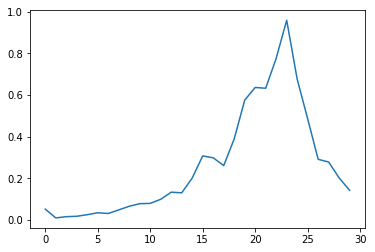

In [44]:
plt.plot(data[4])

In [45]:
#expande as dimensões para poder utilizar na rede
data = np.expand_dims(np.array(data),axis= 2) 

In [46]:
labelsPred = []
#verifica os labels preditos por modelo.
for j in range(len(arquitetura)):
    modelo = arquitetura[j]
    labelsPred = []
    for i in range(6):
        vect = modelo.predict(data[(10*i):10*(i+1)])
        meanV = sum(vect)/10
        if(meanV >= 0.5):
            labelsPred.append(1)
        else:
            labelsPred.append(0)
            
    print(labelsPred)
            

[0, 1, 1, 0, 1, 1]
[1, 1, 1, 0, 1, 1]
[0, 1, 1, 0, 1, 1]
[0, 1, 1, 0, 1, 1]
[0, 1, 1, 0, 1, 1]
[1, 1, 1, 0, 1, 1]
[0, 1, 1, 0, 1, 1]


Como é possível perceber, os 5 modelos identificaram todos os isoladores como defeituosos, uma vez que pelo menos uma das gravações de cada direção indicou defeito para cada isolador. Isso também indica que o ângulo de amostragem do ultrassom faz diferença, uma vez que o defeito foi encontrado em algumas direções e em outras não.